In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
import csv
import seaborn as sns
plt.rc('figure', figsize=[12,8])

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Import data, PCA, K-means

In [2]:
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')

traindf.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
testdf.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
xdata = traindf.drop(['label'], axis=1).values
ydata = traindf['label'].values

pca = PCA(n_components=50)
pca.fit(xdata)
print(sum(pca.explained_variance_ratio_))

0.82555225918


In [5]:
X = pca.transform(xdata)
ypred = KMeans(n_clusters=10).fit_predict(X)

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


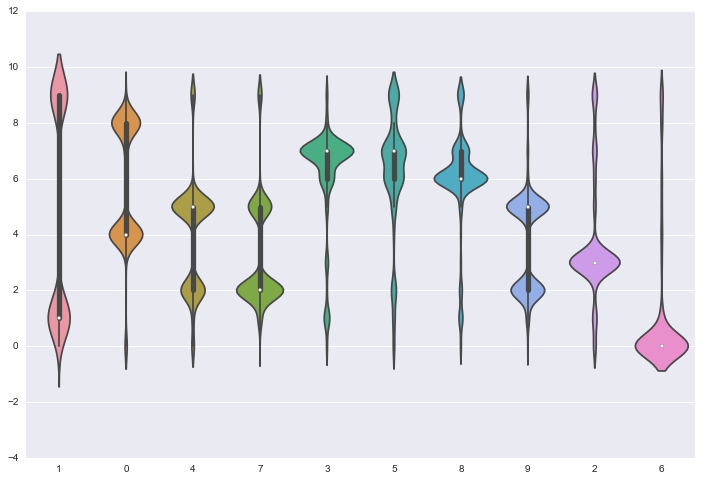

In [6]:
sns.violinplot(ydata, ypred)

Looks like K-means clustering is ineffective (clusters are probably different sizes) - maybe knn will be better.

# KNN

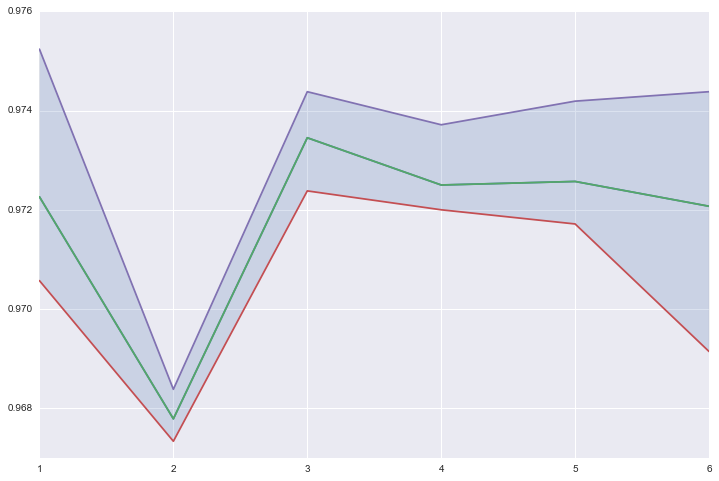

In [7]:
n_neighbours = range(1, 7, 1)
results = []
for n in n_neighbours:
    scores = []
    for train, test in KFold(n=len(ydata), n_folds=4, shuffle=True):
        neigh = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
        neigh.fit(X[train], ydata[train])
        scores.append(neigh.score(X[test], ydata[test]))
    results.append([np.mean(scores), min(scores), max(scores)])
    
plt.plot(n_neighbours, [r[0] for r in results])
plt.plot(n_neighbours, results)
plt.fill_between(n_neighbours, [r[1] for r in results], [r[2] for r in results], alpha=0.2)

In [8]:
scores = []
for train, test in KFold(n=len(ydata), n_folds=4, shuffle=True):
    neigh = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
    neigh.fit(X[train], ydata[train])
    scores.append(neigh.score(X[test], ydata[test]))
print scores

[0.97266666666666668, 0.97085714285714286, 0.97285714285714286, 0.97133333333333338]


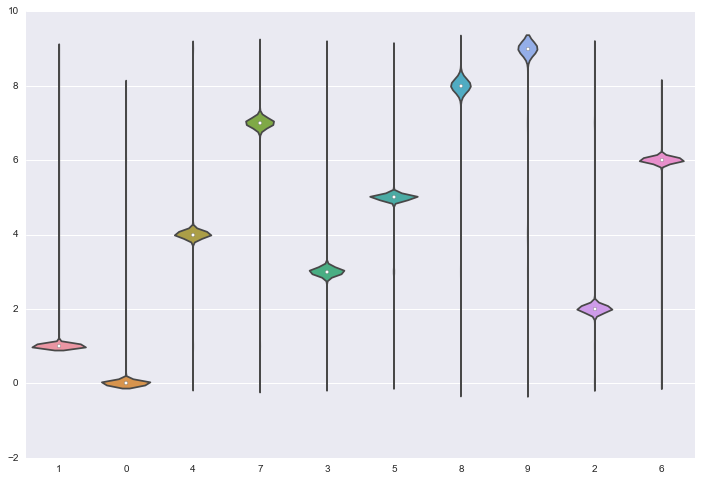

In [9]:
sns.violinplot(ydata, neigh.predict(X))

Looks good!

In [10]:
testdata = testdf.values
XVal = pca.transform(testdata)
predictions = neigh.predict(XVal)

ImageId = range(1, len(predictions)+1)

predictions_file = open("avrknn.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(['ImageId', 'Label'])
open_file_object.writerows(zip(ImageId, predictions))
predictions_file.close()

# Neural net

In [13]:
# Try a neural network
import pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet

ydata_net = np.zeros([len(ydata), 10])
for i, y in enumerate(ydata):
    ydata_net[i, y] = 1
    
ds = SupervisedDataSet(len(xdata[0]), 10)

for i, j in zip(xdata, ydata_net):
    ds.addSample(i, j)
    
net = buildNetwork(len(xdata[0]), 50, 10, bias=True)
trainer = BackpropTrainer(net, ds)

for i in range(20):
    print trainer.train()

output = [net.activate(d) for d in xdata]
predictions = [i.argmax() for i in output]
matches = (predictions == ydata)
accuracy = float(matches.sum()) / float(len(matches))
print accuracy

0.0622487377603
0.0358652461236
0.0333737327176
0.0321406976916
0.0305369054465
0.0295754474819
0.0292784546458
0.0277923922555
0.0268290030949
0.0251514583546
0.024890775141
0.0245770263875
0.0236431327896
0.0228831407511
0.0218470275044
0.0216853214284
0.0217682005413
0.0210439331554
0.0209738799688
0.0205224247583
0.7685


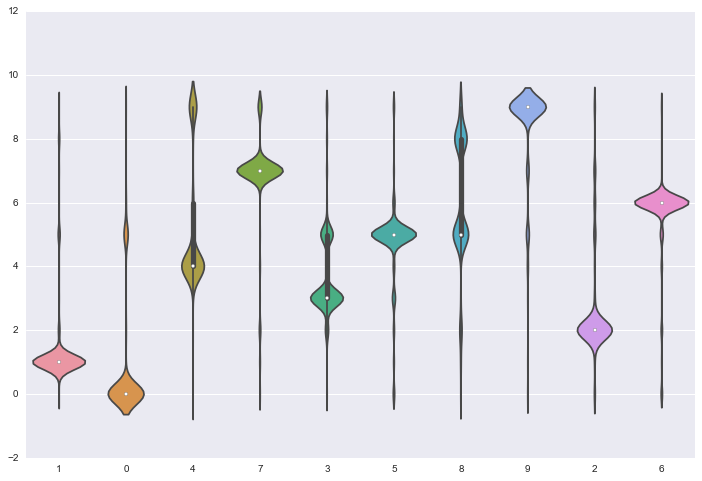

In [14]:
sns.violinplot(ydata, predictions)

Neural net appears to struggle distinguishing some characters.